In [1]:
#! /usr/bin/env python
import tensorflow as tf
import numpy as np
import os
import time
import datetime
import data_helpers
from text_cnn_bn import TextCNN
from tensorflow.contrib import learn
import sys
#sys.setdefaultencoding('utf-8') 
# Parameters
# ==================================================

# Data loading params
tf.flags.DEFINE_float("dev_sample_percentage", .05, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("positive_data_file", "./data/rt-polaritydata/rt-polarity.pos", "Data source for the positive data.")
tf.flags.DEFINE_string("negative_data_file", "./data/rt-polaritydata/rt-polarity.neg", "Data source for the negative data.")

# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 200, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 100, "Number of filters per filter size (default: 128)")#featuremap
tf.flags.DEFINE_float("dropout_keep_prob", 0.7, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.01, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 4, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 200, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")
FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")



Parameters:
ALLOW_SOFT_PLACEMENT=True
BATCH_SIZE=4
CHECKPOINT_EVERY=100
DEV_SAMPLE_PERCENTAGE=0.05
DROPOUT_KEEP_PROB=0.7
EMBEDDING_DIM=200
EVALUATE_EVERY=100
FILTER_SIZES=3,4,5
L2_REG_LAMBDA=0.01
LOG_DEVICE_PLACEMENT=False
NEGATIVE_DATA_FILE=./data/rt-polaritydata/rt-polarity.neg
NUM_CHECKPOINTS=5
NUM_EPOCHS=200
NUM_FILTERS=100
POSITIVE_DATA_FILE=./data/rt-polaritydata/rt-polarity.pos
UNROLLED_LSTM=False



In [4]:
# Data Preparation
# ==================================================

# Load data
'''
def read_data_pos_data(filename):
    with open(filename, 'r',encoding ="utf-8") as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    return data

train_data=read_data_pos_data('./train1.txt')
test_data=read_data_pos_data('./test1.txt')

def y_trans(data):
    for i in range(len(data)):
        if data[i][-1]=='0':
            data[i][-1]=[0,1]
        else :
            data[i][-1]=[1,0]
    return data

train_data=y_trans(train_data)
test_data=y_trans(test_data)

def word2sentece(data):
    temp=[]
    for i in range(len(data)):
        temp.append(' '.join(data[i][:-1]))

    return temp
def ylist2y(data):
    temp=[]
    for i in range(len(data)):
        temp.append(data[i][-1])
    return temp

train_data_x = word2sentece(train_data)
train_data_y = ylist2y(train_data)
'''

'\ndef read_data_pos_data(filename):\n    with open(filename, \'r\',encoding ="utf-8") as f:\n        data = [line.split(\'\t\') for line in f.read().splitlines()]\n    return data\n\ntrain_data=read_data_pos_data(\'./train1.txt\')\ntest_data=read_data_pos_data(\'./test1.txt\')\n\ndef y_trans(data):\n    for i in range(len(data)):\n        if data[i][-1]==\'0\':\n            data[i][-1]=[0,1]\n        else :\n            data[i][-1]=[1,0]\n    return data\n\ntrain_data=y_trans(train_data)\ntest_data=y_trans(test_data)\n\ndef word2sentece(data):\n    temp=[]\n    for i in range(len(data)):\n        temp.append(\' \'.join(data[i][:-1]))\n\n    return temp\ndef ylist2y(data):\n    temp=[]\n    for i in range(len(data)):\n        temp.append(data[i][-1])\n    return temp\n\ntrain_data_x = word2sentece(train_data)\ntrain_data_y = ylist2y(train_data)\n'

In [5]:
'''
max_document_length = max([len(x.split(" ")) for x in train_data_x])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x1 = np.array(list(vocab_processor.fit_transform(train_data_x)))
y1 = np.array(train_data_y)
'''

'\nmax_document_length = max([len(x.split(" ")) for x in train_data_x])\nvocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)\nx1 = np.array(list(vocab_processor.fit_transform(train_data_x)))\ny1 = np.array(train_data_y)\n'

In [6]:
#x1[:3],y1[:3]

In [43]:
w2v = np.load('i2w.npz')#gensim 55823
word2vec_vocab=list(w2v['word'])
word2index=dict([(w,i) for i,w in enumerate(word2vec_vocab)])

def read_data_pos_data(filename):
    with open(filename, 'r',encoding ="utf-8") as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    return data
def y_trans(data):#1,0 좋다
    for i in range(len(data)):
        if data[i][-1]=='0':
            data[i][-1]=[0,1]
        else :
            data[i][-1]=[1,0]
    return data
train_data=read_data_pos_data('./ratings.txt')
train_data=y_trans(train_data)

def x_y_slice(data):
    temp=[]
    for i in range(len(data)):
        temp.append(data[i][:-1])
    return temp
def ylist2y(data):
    temp=[]
    for i in range(len(data)):
        temp.append(data[i][-1])
    return temp
train_data_y = ylist2y(train_data)
train_data_x=x_y_slice(train_data)
train_data_x[0][0]='어리다Verb'

In [44]:
error=[]
def one_hot_encoding(Matrix,data):
    for i,sentence in enumerate(data):
        for j,word in enumerate(sentence):
            try:
                Matrix[i][j]=word2index[word]
            except KeyError:
                error.append([sentence])
                pass
    return Matrix

def Matrix_make(maxlength,num_data):
    a=np.array([0]*maxlength)
    b=[]
    for i in range(num_data):
        b.append(a)
    return np.array(b)

max_document_length = max([len(x) for x in train_data_x])

m=Matrix_make(max_document_length,len(train_data_x))

train_data_x_one_hot=one_hot_encoding(m,train_data_x)

In [45]:
x=np.array(train_data_x_one_hot,dtype='int32')
y=np.array(train_data_y)

In [46]:
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

In [47]:
dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]
print("Vocabulary Size: {:d}".format(len(word2vec_vocab)))
print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))

Vocabulary Size: 55823
Train/Dev split: 190000/10000


In [48]:
x_train.shape[1],y_train.shape[1]

(95, 2)

In [49]:
input_x = tf.placeholder(tf.int32, [None, 95], name="input_x")

In [50]:
input_y = tf.placeholder(tf.float32, [None, 2], name="input_y")

In [51]:
dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

In [52]:
phase_train = tf.placeholder(tf.bool, name='phase_train')

In [53]:
 def batch_norm(x, n_out, phase_train):
        with tf.variable_scope('bn'):
            beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
            gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
            batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
            ema = tf.train.ExponentialMovingAverage(decay=0.5)

            def mean_var_with_update():
                ema_apply_op = ema.apply([batch_mean, batch_var])
                with tf.control_dependencies([ema_apply_op]):
                    return tf.identity(batch_mean), tf.identity(batch_var)

            mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
            normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
        return normed  

In [67]:
word2vec_weight = np.load('word2vec_weight_200_skip_hs.npz')['E']#gensim 55823
word2vec_weight=word2vec_weight.astype('float32')

In [68]:
with tf.device('/cpu:0'), tf.name_scope("embedding"):
            W_embedding = tf.Variable(
                word2vec_weight,
                name="W")
            embedded_chars = tf.nn.embedding_lookup(W_embedding, input_x)
            embedded_chars_expanded = tf.expand_dims(embedded_chars, -1)# BHWC

In [69]:
print (input_x,W_embedding)

Tensor("input_x:0", shape=(?, 95), dtype=int32) Tensor("embedding_2/W/read:0", shape=(55823, 200), dtype=float32, device=/device:CPU:0)


In [70]:
print (embedded_chars,embedded_chars_expanded)

Tensor("embedding_2/embedding_lookup:0", shape=(?, 95, 200), dtype=float32, device=/device:CPU:0) Tensor("embedding_2/ExpandDims:0", shape=(?, 95, 200, 1), dtype=float32, device=/device:CPU:0)


In [89]:
pooled_outputs = []
filter_sizes = [3]
embedding_size = 200
num_filters = 100

In [99]:
for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [3, 200, 1, 100]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(batch_norm(conv,num_filters,phase_train), name="relu")
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [3, 3, 1, 100]
                W2 = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W2")
                b2 = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b2")
                conv = tf.nn.conv2d(
                    tf.transpose(h,[0,1,3,2]),
                    W2,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(batch_norm(conv,num_filters,phase_train), name="relu")
 

In [100]:
print (h)

Tensor("conv-maxpool-3_8/relu:0", shape=(?, 91, 98, 100), dtype=float32)


In [101]:
def GlobalAvgPooling(x):
    assert x.get_shape().ndims == 4
    return tf.reduce_mean(x, [1, 2])

In [110]:
h_pool_flat= (GlobalAvgPooling(h))
num_filters_total=100

In [ ]:
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, 95 - filter_size + 1, 1, 1], # conv한후에 갯수의 크기를 갖는 윈도우생성
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

In [91]:
print (batch_norm(conv,num_filters,phase_train),'\n',conv,'\n',pooled_outputs)

Tensor("bn_1/batchnorm/add_1:0", shape=(?, 93, 1, 100), dtype=float32) 
 Tensor("conv-maxpool-3_4/conv:0", shape=(?, 93, 1, 100), dtype=float32) 
 [<tf.Tensor 'conv-maxpool-3_4/pool:0' shape=(?, 1, 1, 100) dtype=float32>]


In [92]:
num_filters_total = 100 * len(filter_sizes)

In [93]:
h_pool = tf.concat(3, pooled_outputs)

In [94]:
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total]) # 차원을 편다

In [107]:
h_pool,h_pool_flat

(<tf.Tensor 'concat_4:0' shape=(?, 1, 1, 100) dtype=float32>,
 <tf.Tensor 'Mean_1:0' shape=(?, 100) dtype=float32>)

In [108]:
h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

In [109]:
h_drop

<tf.Tensor 'dropout_1/mul:0' shape=(?, 100) dtype=float32>

In [111]:
l2_loss = tf.constant(0.0)
with tf.name_scope("output"):
            W = tf.get_variable(
                "W_2",
                shape=[num_filters_total, 2],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[2]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
            predictions = tf.argmax(scores, 1, name="predictions")

In [112]:
print (W)

Tensor("W_2/read:0", shape=(100, 2), dtype=float32)


In [113]:
 with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(scores, input_y)

In [114]:
l2_constraint = tf.constant(3.0)

In [116]:
loss = tf.reduce_mean(losses) + 0.01 * l2_loss

In [117]:
loss,l2_loss,losses

(<tf.Tensor 'add:0' shape=() dtype=float32>,
 <tf.Tensor 'output/add_1:0' shape=() dtype=float32>,
 <tf.Tensor 'loss/Reshape_2:0' shape=(?,) dtype=float32>)

In [118]:
optimizer = tf.train.AdagradOptimizer(0.01)

In [97]:
grads_and_vars = optimizer.compute_gradients(loss)

In [101]:
global_step = tf.Variable(0, name="global_step", trainable=False)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [103]:
print (train_op)

name: "Adagrad"
op: "AssignAdd"
input: "global_step"
input: "Adagrad/value"
attr {
  key: "T"
  value {
    type: DT_INT32
  }
}
attr {
  key: "_class"
  value {
    list {
      s: "loc:@global_step"
    }
  }
}
attr {
  key: "use_locking"
  value {
    b: false
  }
}



In [7]:
cnn = TextCNN(
            sequence_length=x_train.shape[1],
            num_classes=y_train.shape[1],
            vocab_size=len(vocab_processor.vocabulary_),
            embedding_size=FLAGS.embedding_dim,
            filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
            num_filters=FLAGS.num_filters,
            l2_reg_lambda=FLAGS.l2_reg_lambda)

In [19]:
print (cnn.W_e.read_value())

Tensor("read:0", shape=(47086, 100), dtype=float32)


In [4]:
data = np.load('3,4,5.npz')#128128
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(22400, 0.87239987)

In [72]:
data = np.load('5.npz')# overfit x
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(29600, 0.87220007)

In [71]:
data = np.load('7.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(24200, 0.87110007)

In [70]:
data = np.load('6.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(24200, 0.87110001)

In [73]:
data = np.load('4.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(34200, 0.87180007)

In [69]:
data = np.load('3.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(29000, 0.87230003)

In [74]:
data = np.load('2.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(33200, 0.86990011)

In [75]:
data = np.load('1.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(16700, 0.85410011)

In [77]:
data = np.load('3,6,7.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(48300, 0.87683344)

In [86]:
data = np.load('8.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(23900, 0.87750012)

In [5]:
data = np.load('9.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(26600, 0.87583345)

In [54]:
data = np.load('2,4,6_bn.npz')
100*(np.argmax(data['accuray'])+1),np.max(data['accuray'])

(47600, 0.8773334)

In [109]:
data = np.load('2,4,6.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(29600, 0.87216675)

In [27]:
data = np.load('8_w.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(38400, 0.86983347)

In [22]:
data = np.load('3_w.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(36200, 0.87333339)

In [85]:
data = np.load('3,4,5_w.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(36800, 0.87383342)

In [93]:
data = np.load('3_w_128.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(35700, 0.87300003)

In [153]:
data = np.load('4_w_1282.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(22200, 0.87166673)

In [154]:
data = np.load('4_w_128.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(26500, 0.87633342)

In [164]:
data = np.load('4_w_200.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(35500, 0.87433332)

In [92]:
data = np.load('3_w_200.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(63200, 0.87350005)

In [33]:
data = np.load('5_w_200.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(23500, 0.87433344)

In [154]:
data = np.load('3cnn2_w_200.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(40400, 0.8720001)

In [237]:
data = np.load('3cnn2_w_200_T.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(36300, 0.87483346)

In [419]:
data = np.load('3cnn2_w_200_T_no.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(33700, 0.87566674)

In [504]:
data = np.load('3cnn2_w_200_T_no2.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(18300, 0.86716676)

In [483]:
data = np.load('5cnn2_w_200_T_no2.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(26200, 0.87233347)

In [501]:
data = np.load('5cnn3_w_200_T_no2.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(33700, 0.87283337)

In [541]:
data = np.load('3cnn3_w_200_T_no2.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(24700, 0.87533343)

In [892]:
data = np.load('3cnn3_w_200_T_no0.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(18100, 0.86100012)

In [32]:
data = np.load('3cnn3_w_200_no0.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(3200, 0.55066675)

In [317]:
data = np.load('cnn_w2v_bn_dr_l2.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(33600, 0.87983346)

In [1244]:
data = np.load('3cnn_w2v_bn_.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(13000, 0.86066681)

In [136]:
data = np.load('3cnn_v.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(15300, 0.86933345)

In [135]:
data = np.load('3cnn_w2v.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(16800, 0.87583339)

In [132]:
data = np.load('3cnn_w2v_bn.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(21200, 0.87400001)

In [117]:
data = np.load('3cnn_w2v_bn1.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(7100, 0.87133348)

In [341]:
data = np.load('3cnn_w2v_bn1_25.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(11100, 0.87283343)

In [367]:
data = np.load('3cnn_w2v_bn1_35.npz')
100*(np.argmax(data['loss'])+1),np.max(data['loss'])

(9200, 0.87100005)

In [201]:
np.savez('cnn3_w2v.npz',acc=data['acc'])

In [59]:
data = np.load('cnn_2_f_3_3_w2v_bn_2.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(26300, 0.87700009)

In [387]:
data = np.load('cnn_2_f_3_3_w2v_bn_3.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(20400, 0.87883341)

In [202]:
data = np.load('cnn3_w2v.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(14000, 0.8720001)

In [8]:
data = np.load('cnn_f_3.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(14200, 0.86933339)

In [392]:
data = np.load('3cnn_f_3_w2v.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(12200, 0.87250006)

In [5]:
data = np.load('3cnn_f_3_w2v_3.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(16800, 0.87750018)

In [184]:
data = np.load('3cnn_f_3_w2v_b3.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(38400, 0.90000004)

In [267]:
data = np.load('3_cnn2_GP.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(6600, 0.9000001)

In [385]:
data = np.load('3_cnn_f_3_w2v_gp.npz')
100*(np.argmax(data['acc'])+1),np.max(data['acc'])

(17600, 0.85713649)

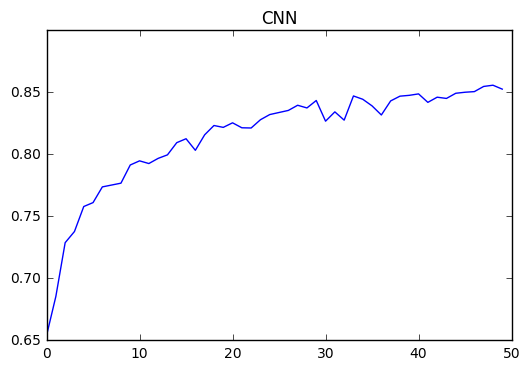

average : 0.86444
-10average : 0.86455
max : 0.869333


In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

x=range(len(data['acc'][:50]))
y=data['acc'][:50]

plt.title('CNN')
plt.plot(x,y)
plt.show()
print ('average : '+str(np.average(data['acc'][-50:])))
print ('-10average : '+str(np.average(data['acc'][-10:])))
print ('max : '+str(np.max(data['acc'])))

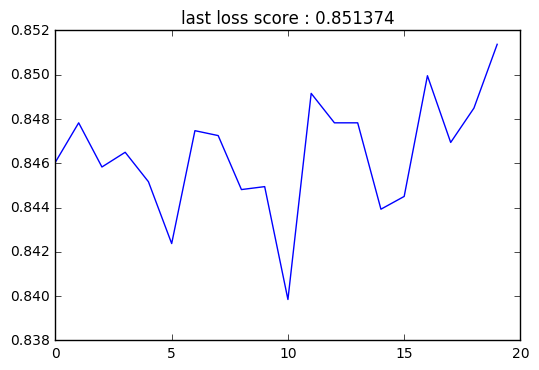

average : 0.846405
-10average : 0.846986
max : 0.857136


In [384]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

x=range(len(data['acc'][-20:]))
y=data['acc'][-20:]

plt.title('last loss score : %f' %y[-1])
plt.plot(x,y)
plt.show()
print ('average : '+str(np.average(data['acc'][-20:])))
print ('-10average : '+str(np.average(data['acc'][-10:])))
print ('max : '+str(np.max(data['acc'])))

In [142]:
data_loss = np.load('2,4,6_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(23100, 0.31680444)

In [144]:
data_loss = np.load('9_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(24100, 0.30786249)

In [25]:
data_loss = np.load('8_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(17600, 0.30367121)

In [29]:
data_loss = np.load('8_w_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(23200, 0.31954449)

In [146]:
data_loss = np.load('3_w_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(61000, 0.31945542)

In [131]:
data_loss = np.load('4_w_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(22800, 0.30698147)

In [129]:
data_loss = np.load('5_w_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(23400, 0.31236574)

In [127]:
data_loss = np.load('3,4,5_w_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(23600, 0.30886912)

In [38]:
data_loss = np.load('3cnn2_w_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(10900, 0.31758925)

In [20]:
data_loss = np.load('3cnn3_w_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(3300, 0.71348268)

In [76]:
data_loss = np.load('3cnn_w2v_bn_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(100, 0.69054949)

In [123]:
data_loss = np.load('3cnn_v_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(16900, 0.31871113)

In [157]:
data_loss = np.load('3cnn_w2v_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(10600, 0.30476409)

In [103]:
np.savez('cnn_2_f_3_3_w2v_bn_3_loss.npz',loss=data_loss['loss'])

In [168]:
data_loss = np.load('cnn_2_f_3_3_w2v_bn_2_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(18100, 0.3131299)

In [174]:
data_loss= np.load('cnn_2_f_3_3_w2v_bn_3_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(16900, 0.31164518)

In [182]:
data_loss = np.load('cnn_f_3_loss.npz')
100*(np.argmin(data_loss['loss'])+1),np.min(data_loss['loss'])

(18100, 0.31718382)

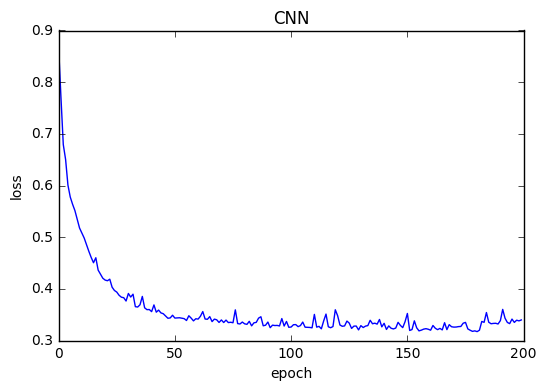

average : 0.34341


In [184]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib

x=range(len(data_loss['loss'][:200]))

y=data_loss['loss'][:200]

plt.title('CNN')
plt.plot(x,y)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
print ('average : '+str(data_loss['loss'][50]))